I asked chatGPT a question (2023) regarding Julia VS Python
![rnn](./JuliaOrPython.png)

## <span style="color:orange">Recurrent Models with FluxML</span>

#### <span style="color:orange"> Flux does offer out of the box a set of recurrence functionalities in specific layers. Remember that recurrent models can come across as being more complicated than necessary. In general we are still dealing with the same type of funcational relationship, $\hat{y} = f(X_i) = f_{rnn}(X_t)$ where previously y_hat was either a single dimension or multiple dimensions, here $y_{hat} = [y_t , h_t]$ where $h_t$ is an input into the new time point (memory carry on) so that we have $X_t = [ x_t , h_{t-1}]$. The dependency can be seen as $\hat{y}_t = f(x_t,h_{t-1}), h_t = g(h_{t-1},x_t)$ </span>

- This basic recurrence relationship says that at each point we take the $h_{t-1}$ from the previous time step 't-1', we also use the current inputs at time t, $x_t$ and then produce an output which is has 2 components, $y_t$ and $h_t$ (where $h_t$ feeds into $t+1$). If we focus on a single time point, we are still doing the functional mapping that we had before with the chain of Dense layers.

- The below image [link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Fswlh%2Fintroduction-to-recurrent-neural-networks-rnns-347903dd8d81&psig=AOvVaw3xmMdMdDizNUUWXy021QUO&ust=1673451409556000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCOCStLiqvfwCFQAAAAAdAAAAABA_) shows how this looks in a model diagram for **seq-to-seq** (**many to many**)

![rnn](./rnn1.png)

- also The below image [link source](https://www.ibm.com/topics/recurrent-neural-networks) shows how this looks

![rnn](./rnn2.jpeg)

----------------

#### <span style="color:orange"> $W_h$ is the weight matrix (tranformation) on the 'hidden inputs' $h_{t-1}$ that come from the previous unit's 'hidden' output, $W_x$ is the weight matrix (transformation) upon the inputs at the current time $x_t$. $W_y$ is the transformation weight matrix applied to the 'current' hidden value produced from the cell that after a non-linear transformation (activation function) produces the output $\hat{y}_t$. Training involves learning the values of the weights/parameters for these matrices.</span>

### <span style="color:orange"> $h_t = tahn(b_h + W_h^t h_{t-1} + W_x^t x_t)$ </span>
### <span style="color:orange"> $\hat{y}_t = softmax(b_y + W_{y}^{t} h_t)$ </span>

RNN can bring to mind the Kalman Filter

In [1]:
import Pkg
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
  [587475ba] Flux v0.13.11


In [2]:
using Flux
using Zygote
using Plots
using Distributions

In [3]:
#example of usage of the RNN unit
h_dim = 5 #hidden dimension
x_dim = 2 #input dimension at time t
y_dim = 1 #the output dimension that 'we' see

rnn_tmp = RNN( x_dim , h_dim ) #produces the cell
x_t1 = Float32.( [1,2] ) #some arbitrary input data
println( rnn_tmp( x_t1 ) ) #print the output h_t1 from the cell

Float32[-0.56370807, -0.39385366, 0.7875645, -0.8744197, 0.12622719]


### <span style="color:orange"> It is key to know that this cell is different from the Dense layers in that it maintains the state between executions since it is **stateful**. This means it holds the state via a closure inside the function reference</span>

In [4]:
x_t1 = Float32.( [1,2] ) #some arbitrary input data
println( rnn_tmp( x_t1 ) ) #print the output h_t1 from the cell
#print multiple times to see the changes
display( [ rnn_tmp( x_t1 ) for _ in 1:4 ] )

Float32[-0.713185, 0.595224, 0.9438289, 0.0764499, 0.7015635]


4-element Vector{Vector{Float32}}:
 [-0.68775934, -0.113666244, 0.8882481, -0.041872323, 0.13901944]
 [-0.6618453, 0.35281876, 0.96226645, -0.31885484, 0.3110932]
 [-0.69812596, 0.19833593, 0.92629987, -0.01294922, 0.41889405]
 [-0.674529, 0.1612533, 0.9370686, -0.16336371, 0.24792035]

### <span style="color:orange"> Since the RNN unit maintains and handles the state between subsequent uses we can abstractly use it in the ML pipeline as we used the Dense layer. From above notice that we produced hidden representation responses from inputs, but not the predictions $\hat{y}$ since those are done separately. </span>

### <span style="color:orange"> The RNN function implements $h_t = tahn(b_h + W_h^t h_{t-1} + W_x^t x_t)$ but $\hat{y}_t = softmax(b_y + W_{y}^{t} h_t)$ is not. The $W_{y}$ matrix is not provided by the RNN layer and must be supplied by the user. </span>

In [5]:
#we feed the model with 'x_dim' data, it produces a hidden vector 'h_dim' and outputs a 'y_dim' vector at each time
rnn_model1 = Chain( RNN( x_dim => h_dim ) , Dense( h_dim => y_dim , relu ), softmax ) 

Chain(
  Recur(
    RNNCell(2 => 5, tanh),              # 45 parameters
  ),
  Dense(5 => 1, relu),                  # 6 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 51 parameters,
          # plus 1 non-trainable, 5 parameters, summarysize 580 bytes.

In [6]:
#try out the model
rnn_model1( x_t1 )

1-element Vector{Float32}:
 1.0

In [7]:
[ rnn_model1( x_t1 ) for _ in 1:4 ]

4-element Vector{Vector{Float32}}:
 [1.0]
 [1.0]
 [1.0]
 [1.0]

In [8]:
#test the model with hypothetical data
x_length = 5
#generate some random data as inputs, to be treated as a sequence
x_seq = [ rand( Float32 , x_dim ) for i = 1:x_length ] #sequence data
[ rnn_model1( xt ) for xt in x_seq ] #predicted y_t data from the RNN
#this is <sequence to sequence> <many to many>

5-element Vector{Vector{Float32}}:
 [1.0]
 [1.0]
 [1.0]
 [1.0]
 [1.0]

### Let us look at how we can use batches, where a batch is a set of independent sentences in a single datastructure

In [9]:
batch_num = 4
x_seq = [ rand( Float32 , x_dim , batch_num ) for i = 1:x_length ]
display( size( x_seq[1] ) )
y_seq = [ rand( Float32 , y_dim , batch_num ) for i = 1:x_length ]
display( size( y_seq[1] ) )

function loss1(x, y)
    Flux.reset!(rnn_model1)
    println( "x " , [ size(xi) for (xi,yi) in zip(x,y) ] )
    println( "y " , [ size(yi) for (xi,yi) in zip(x,y) ] )
    #the way Julia does broadcasting means that we don't need to reset between batches
    return sum( [ Flux.crossentropy(rnn_model1(x_b),y_b) for (x_b,y_b) in zip(x,y) ] )
end
println( "loss1 ",loss1(x_seq,y_seq) )

function loss2(x, y)
    Flux.reset!(rnn_model1)
    loss = 0
    for (x_b,y_b) in zip(x,y)
        loss += Flux.mse(rnn_model1(x_b),y_b)
    end
    return loss
end
println( "loss2 ",loss2(x_seq,y_seq) )

(2, 4)

(1, 4)

x [(2, 4), (2, 4), (2, 4), (2, 4), (2, 4)]
y [(1, 4), (1, 4), (1, 4), (1, 4), (1, 4)]
loss1 -2.5052677e-7
loss2 2.043422


### <span style="color:orange"> If you need to use the RNN and not have it dependent upon the previous state (eg. independent sentences), then you can use the **Flux.reset!(rnn_model)** command so the previous history variables are removed </span>

In [10]:
#start a new model fresh again
x_categories = [ "happy" , "sad" ]
y_categories = [ "steak" , "chicken" , "soup" ]
h_dim = 4 #hidden dimension
x_dim = length( x_categories ) #input dimension at time t
y_dim = length( y_categories ) #the output dimension that 'we' see
sequence_length = 8
p_emotions = [ 0.7 , 0.3 ] #higher prob of happy

rnn_model2 = Chain( RNN( x_dim => h_dim ) , Dense( h_dim => y_dim,relu) , softmax )

Chain(
  Recur(
    RNNCell(2 => 4, tanh),              # 32 parameters
  ),
  Dense(4 => 3, relu),                  # 15 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 47 parameters,
          # plus 1 non-trainable, 4 parameters, summarysize 564 bytes.

In [11]:
#no updating via reset which resets the RNN hidden state
x_tmp = rand( Float32 , x_dim )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
#updating
display( "----updating (no reset)----" )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )

Float32[0.2912296, 0.2912296, 0.4175408]
Float32[0.2912296, 0.2912296, 0.4175408]
Float32[0.2912296, 0.2912296, 0.4175408]
Float32[0.2912296, 0.2912296, 0.4175408]


"----updating (no reset)----"

Float32[0.23654358, 0.23654358, 0.52691287]
Float32[0.20400864, 0.24455863, 0.5514328]
Float32[0.19078095, 0.23436074, 0.5748583]
Float32[0.1832931, 0.2408233, 0.57588357]


#### (make some data on food choices) dependency is that when happy is seen: steak, then on subsequent happy: chicken, upon sad: soup (constantly)

the key is here that there should be memory of having seen sad which overrides newer observations of happy so that the menu serves soup regardless and that the RNN stores this information

In [12]:
function RNN_X_Data_Food( sequence_length )
    #rand(x_categories,sequence_length)
    return x_categories[ rand(Categorical(p_emotions),sequence_length) ] 
end
x_seq_cold = RNN_X_Data_Food( sequence_length )
println( x_seq_cold )
#dependency is that when happy is seen: steak, then on subsequent happy: chicken, upon sad: soup 
function RNN_Y_Data_Food( x_seq_cold )
    y_seq_cold = []
    prev_xx = ""
    for xx in x_seq_cold
        if( xx == "happy" && prev_xx != "happy" ) 
            push!( y_seq_cold , "steak" )
        elseif( xx == "happy" )
            push!( y_seq_cold , "chicken" )
        else
            push!( y_seq_cold , "soup" )
        end
        prev_xx = xx
    end
    return y_seq_cold
end
println( RNN_Y_Data_Food(x_seq_cold) ) #output food agenda
println("-------------")
x_seq_cold = RNN_X_Data_Food( sequence_length )
println( x_seq_cold )
println( RNN_Y_Data_Food(x_seq_cold) ) #output food agenda

["sad", "sad", "happy", "happy", "sad", "happy", "happy", "happy"]
Any["soup", "soup", "steak", "chicken", "soup", "steak", "chicken", "chicken"]
-------------
["sad", "sad", "happy", "happy", "sad", "happy", "sad", "happy"]
Any["soup", "soup", "steak", "chicken", "soup", "steak", "soup", "steak"]


In [13]:
NN = 300
#generate the stochastic data upon the rule set defined in the functions
x_train_cold = [ RNN_X_Data_Food(sequence_length) for _ in 1:NN ]
display( x_train_cold[1:3] )
y_train_cold = RNN_Y_Data_Food.(x_train_cold)
display( y_train_cold[1:3] )
x_test_cold = [ RNN_X_Data_Food(sequence_length) for _ in 1:NN ]
y_test_cold = RNN_Y_Data_Food.(x_test_cold);

3-element Vector{Vector{String}}:
 ["happy", "happy", "happy", "happy", "happy", "sad", "happy", "sad"]
 ["sad", "sad", "happy", "happy", "happy", "sad", "sad", "happy"]
 ["sad", "happy", "happy", "happy", "happy", "sad", "happy", "happy"]

3-element Vector{Vector{Any}}:
 ["steak", "chicken", "chicken", "chicken", "chicken", "soup", "steak", "soup"]
 ["soup", "soup", "steak", "chicken", "chicken", "soup", "soup", "steak"]
 ["soup", "steak", "chicken", "chicken", "chicken", "soup", "steak", "chicken"]

In [14]:
#put the label data into one-hot-batch
x_train = [ Flux.onehotbatch( x_train_cold[ii] , x_categories ) for ii in 1:length(x_train_cold) ]
display( x_train[1:4] )
display( x_train[1] )
x_test = [ Flux.onehotbatch( x_test_cold[ii] , x_categories ) for ii in 1:length(x_test_cold) ];
y_train = [ Flux.onehotbatch( y_train_cold[ii] , y_categories ) for ii in 1:length(y_train_cold) ];
display( y_train[1:4] )
display( y_train[1] )
y_test = [ Flux.onehotbatch( y_test_cold[ii] , y_categories ) for ii in 1:length(y_test_cold) ];

4-element Vector{OneHotArrays.OneHotMatrix{UInt32, 2, Vector{UInt32}}}:
 [1 1 … 1 0; 0 0 … 0 1]
 [0 0 … 0 1; 1 1 … 1 0]
 [0 1 … 1 1; 1 0 … 0 0]
 [1 1 … 1 1; 0 0 … 0 0]

2×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1

4-element Vector{OneHotArrays.OneHotMatrix{UInt32, 3, Vector{UInt32}}}:
 [1 0 … 1 0; 0 1 … 0 0; 0 0 … 0 1]
 [0 0 … 0 1; 0 0 … 0 0; 1 1 … 1 0]
 [0 1 … 1 0; 0 0 … 0 1; 1 0 … 0 0]
 [1 0 … 0 0; 0 1 … 1 1; 0 0 … 0 0]

3×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  1  1  1  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1

In [15]:
println( x_train_cold[1] ) #labels input
println( y_train_cold[1] ) #food output
println( x_train[1] ) #in numerical 1hot
println( y_train[1] ) #in numerical 1hot

y_hat = rnn_model2( x_train[1] ) #inspect what the model predicts given some training data (not trained yet)
println( y_hat ) #raw prediction vectors
println( Flux.onecold( y_hat , y_categories ) ) #the predicted 
Flux.crossentropy( y_hat , y_train[1] ) #the error

["happy", "happy", "happy", "happy", "happy", "sad", "happy", "sad"]
Any["steak", "chicken", "chicken", "chicken", "chicken", "soup", "steak", "soup"]
Bool[1 1 1 1 1 0 1 0; 0 0 0 0 0 1 0 1]
Bool[1 0 0 0 0 0 1 0; 0 1 1 1 1 0 0 0; 0 0 0 0 0 1 0 1]
Float32[0.17469576 0.17469576 0.17469576 0.17469576 0.17469576 0.16679455 0.17469576 0.16679455; 0.21983702 0.21983702 0.21983702 0.21983702 0.21983702 0.2687005 0.21983702 0.2687005; 0.6054672 0.6054672 0.6054672 0.6054672 0.6054672 0.5645049 0.6054672 0.5645049]
["soup", "soup", "soup", "soup", "soup", "soup", "soup", "soup"]


1.3365629f0

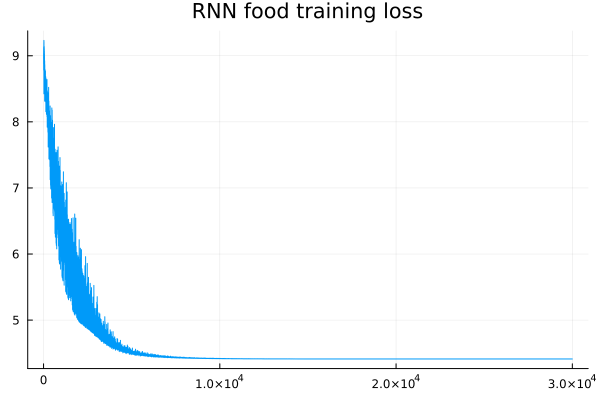

In [16]:
rnn_model2 = Chain( RNN(2=>4) , Dense(4=>3,sigmoid) , softmax )
data = Flux.DataLoader( (x_train, y_train) , batchsize=1 , shuffle=true )
opt = Flux.setup( Flux.Adam(0.001) , rnn_model2 )

losses = []
for epoch in 1:100
    for ( x , y ) in data #we get the 1 hot encoded here but each column is part of a sequence (step)
        
        x_us = Flux.unstack(Float32.(x[1]),dims=2) #puts the data samples into separate vectors from columns
        y_us = Flux.unstack(Float32.(y[1]),dims=2)

        Flux.reset!(rnn_model2) #important or else the model takes the 'hidden' values from previous usage 
        
        loss_tmp, grads = Flux.withgradient( rnn_model2 ) do model                        
            loss = 0
            for ii in 1:length(x_us)
               
                    y_hat = model( x_us[ii] )
                    loss += Flux.crossentropy( y_hat , y_us[ii] )
                
            end
            return loss
        end     
        Flux.update!( opt , rnn_model2 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    
end
p1 = plot( losses , title="RNN food training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)

In [17]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model2 )
    y_hat = []
    for ii in 1:length(x_us)               
        meal = Flux.onecold( rnn_model2(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["soup", "soup", "soup", "steak", "chicken", "soup", "steak", "chicken"]
y_hat: Any["soup", "soup", "soup", "steak", "chicken", "soup", "steak", "chicken"]
       y: ["steak", "soup", "steak", "soup", "soup", "soup", "soup", "soup"]
y_hat: Any["steak", "soup", "steak", "soup", "soup", "soup", "soup", "soup"]
       y: ["soup", "steak", "chicken", "soup", "steak", "chicken", "soup", "steak"]
y_hat: Any["soup", "steak", "chicken", "soup", "steak", "chicken", "soup", "steak"]
       y: ["steak", "chicken", "chicken", "soup", "steak", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "soup", "steak", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "soup"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "soup"]
       y: ["steak", "soup", "soup", "steak", "soup", "steak", "chicken", "chicken"]
y_hat: Any["steak", "soup", "soup", "steak", "soup", "st

#### <span style="color:orange">Let us make the data generated a harder challenge and use LSTM units rather than RNN</span>

- The data now will differ in that if a sad emotion has been seen at any point in the past 'chicken' ceases to be a meal option

In [18]:
function RNN_X_Data_Food2( sequence_length )
    return x_categories[ rand(Categorical(p_emotions),sequence_length) ] 
end
x_seq_cold = RNN_X_Data_Food2( sequence_length )
println( x_seq_cold )
#dependency is that when happy is seen: steak, then on subsequent happy: chicken, upon sad: soup (no more chicken option)
function RNN_Y_Data_Food2( x_seq_cold )
    y_seq_cold = []
    prev_xx = ""
    seen_sad = false
    for xx in x_seq_cold
        if( (xx == "happy" && prev_xx != "happy") || (seen_sad == true && xx != "sad") )
            push!( y_seq_cold , "steak" )
        elseif( xx == "happy" )
            push!( y_seq_cold , "chicken" )
        else
            push!( y_seq_cold , "soup" )
            seen_sad = true
        end
        prev_xx = xx
    end
    return y_seq_cold
end
println( RNN_Y_Data_Food2(x_seq_cold) ) #output food agenda
println("-------------")
x_seq_cold = RNN_X_Data_Food2( sequence_length )
println( x_seq_cold )
println( RNN_Y_Data_Food2(x_seq_cold) ) #output food agenda

["happy", "sad", "happy", "sad", "sad", "happy", "happy", "sad"]
Any["steak", "soup", "steak", "soup", "soup", "steak", "steak", "soup"]
-------------
["sad", "sad", "sad", "happy", "happy", "happy", "happy", "happy"]
Any["soup", "soup", "soup", "steak", "steak", "steak", "steak", "steak"]


In [19]:
NN = 300
#generate the stochastic data upon the rule set defined in the functions
x_train_cold = [ RNN_X_Data_Food2(sequence_length) for _ in 1:NN ]
y_train_cold = RNN_Y_Data_Food2.(x_train_cold)
x_test_cold = [ RNN_X_Data_Food2(sequence_length) for _ in 1:NN ]
y_test_cold = RNN_Y_Data_Food2.(x_test_cold);
println( x_train_cold[1] )
println( y_train_cold[1] )

["sad", "sad", "happy", "happy", "happy", "happy", "sad", "sad"]
Any["soup", "soup", "steak", "steak", "steak", "steak", "soup", "soup"]


In [20]:
#put the label data into one-hot-batch
x_train = [ Flux.onehotbatch( x_train_cold[ii] , x_categories ) for ii in 1:length(x_train_cold) ]
x_test = [ Flux.onehotbatch( x_test_cold[ii] , x_categories ) for ii in 1:length(x_test_cold) ];
y_train = [ Flux.onehotbatch( y_train_cold[ii] , y_categories ) for ii in 1:length(y_train_cold) ];
y_test = [ Flux.onehotbatch( y_test_cold[ii] , y_categories ) for ii in 1:length(y_test_cold) ];
display( x_train[1] )
display( y_train[1] )

2×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  1  1

3×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  1  1

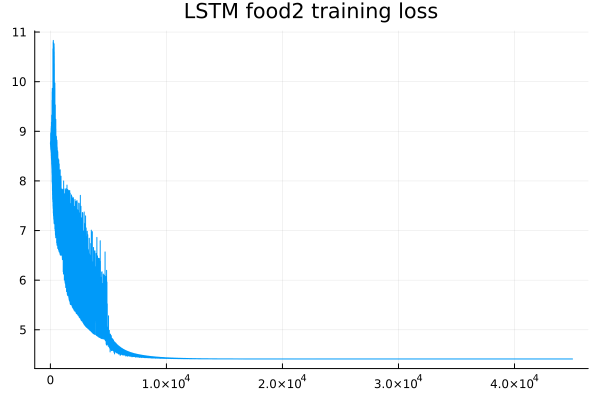

In [21]:
#also add another LSTM unit
rnn_model3 = Chain( LSTM(2=>6) , LSTM(6=>4) , Dense(4=>3,sigmoid) , softmax )
data = Flux.DataLoader( (x_train, y_train) , batchsize=1 , shuffle=true )
opt = Flux.setup( Flux.Adam(0.001) , rnn_model3 )

losses = []
for epoch in 1:150
    for ( x , y ) in data
        
        x_us = Flux.unstack(Float32.(x[1]),dims=2)
        y_us = Flux.unstack(Float32.(y[1]),dims=2)
        
        Flux.reset!(rnn_model3) #important or else the model takes the 'hidden' values from previous usage 
        
        loss_tmp, grads = Flux.withgradient( rnn_model3 ) do model                        
            loss = 0
            for ii in 1:length(x_us)
                
                y_hat = model( x_us[ii] )
                loss += Flux.crossentropy( y_hat , y_us[ii] )
                
            end
            return loss
        end     
        Flux.update!( opt , rnn_model3 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    
end
p1 = plot( losses , title="LSTM food2 training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)

In [22]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model3 )
    y_hat = []
    for ii in 1:length(x_us)               
        meal = Flux.onecold( rnn_model3(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["soup", "soup", "soup", "steak", "soup", "steak", "soup", "soup"]
y_hat: Any["soup", "soup", "soup", "steak", "soup", "steak", "soup", "soup"]
       y: ["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
       y: ["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
       y: ["soup", "steak", "steak", "soup", "steak", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "steak", "soup", "steak", "steak", "steak", "steak"]
       y: ["steak", "soup", "soup", "soup", "steak", "soup", "steak", "soup"]
y_hat: Any["steak", "soup", "soup", "soup", "steak", "soup", "steak", "soup"]
       y: ["steak", "soup", "soup", "steak", "steak", "soup", "soup", "steak"]
y_hat: Any["steak", "soup", "soup", "steak", "steak", "soup", "soup", "steak"]
       y: ["steak", "chicken", "soup", "st

#### <span style="color:orange">The examples we have used have had data packed (loaded) with <u>batchsize = 1</u>. This may not be optimal as the optimization is learning upon single sequences rather than adopt the minibatch approach as used previously.</span>

- we need to still pass in each step in the x_t data and not the whole series but passing a set of data points all pertaining to the same time point (step number)

- to work with batches we need to pass each step to the RNN model as (x_dim, batch_dim), that is a matrix of x_dim features on rows and that many columns as indepenent sequences

In [23]:
#how we can stack multiple observations that potentially pertain to a single step from multiple batches
m = Chain( LSTM(2=>4) , Dense(4=>3,sigmoid) , softmax )
m( rand(Float32,2,10) )
rr = Float32.(Flux.stack([[1,0],[0,1],[1,0],[1,0],[0,1],[1,0],[1,0],[1,0],[1,0],[1,0]],dims=2))
m( rr )

3×10 Matrix{Float32}:
 0.339533  0.343266  0.338234  0.338931  …  0.340227  0.33983   0.33968
 0.332299  0.331138  0.332542  0.33251      0.332073  0.332465  0.332558
 0.328168  0.325596  0.329224  0.328559     0.3277    0.327705  0.327763

In [24]:
for tt in eachindex([[12,3],[1,2,3],[3,2,1]])
    println(tt)
end

1
2
3


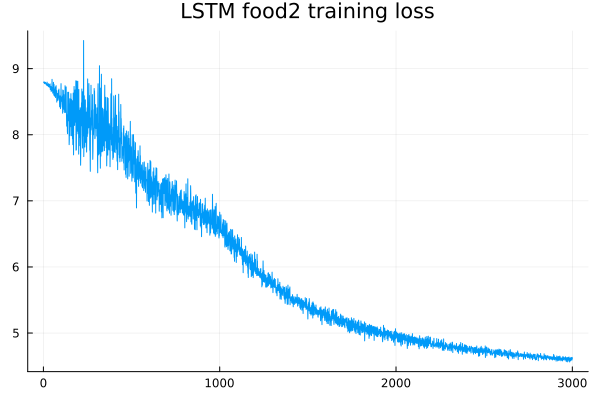

In [25]:
rnn_model4 = Chain( LSTM(2=>6) , LSTM(6=>4) , Dense(4=>3,sigmoid) , softmax ) #same model
opt = Flux.setup( Flux.Adam(0.001) , rnn_model4 ) #same optimizer
#change the batch size so that multiple sequence samples are passed at the same time
data = Flux.DataLoader( ( x_train , y_train ) , batchsize = 10 , shuffle = true )

losses = []
for epoch in 1:100
    #each x and y is a vector holding separate full sequence runs length = batch size
    #x[1] is here a batch_num = 1 and size = (x_dim,sequence_length)
    #x[1][:,1] is a x_dim vector for the first step features of batch num = 1 (x data of step 1 batch 1)
    #x[ii][:,tt] is the batch num = 1 x_dim vector for the tt_th step (x data of step tt of batch ii)
    #x[:][:,1] takes from all the batches the first x_dim data for each step of the sequences
    for ( x , y ) in data 
     
        x_batch_tt = [Flux.stack([Float32.(x[ii][:,tt]) for ii in 1:length(x)],dims=2) for tt in 1:length(x[1][1,:]) ]
        
        y_batch_tt = [Flux.stack([Float32.(y[ii][:,tt]) for ii in 1:length(y)],dims=2) for tt in 1:length(y[1][1,:]) ]
        
        #x_us = Flux.unstack(Float32.(x[1]),dims=2)
        #y_us = Flux.unstack(Float32.(y[1]),dims=2)
        
        Flux.reset!(rnn_model4) #important or else the model takes the 'hidden' values from previous usage 
        
        loss_tmp, grads = Flux.withgradient( rnn_model4 ) do model                        
            loss = 0
            for ii in 1:length( x_batch_tt )
                #println(x_batch[ii])
                y_hat = model( x_batch_tt[ii] )
                loss += Flux.crossentropy( y_hat , y_batch_tt[ii] )                
            end
            return loss
        end
        
        Flux.update!( opt , rnn_model4 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
        
    end
    #break
end
p1 = plot( losses , title="LSTM food2 training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)


In [26]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model4 )
    y_hat = []
    for ii in 1:length(x_us)               
        meal = Flux.onecold( rnn_model4(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]
       y: ["steak", "chicken", "chicken", "chicken", "soup", "steak", "steak", "soup"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "soup", "steak", "steak", "soup"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "soup"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "soup"]
       y: ["soup", "steak", "soup", "steak", "soup", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "soup", "steak", "soup", "steak", "steak", "steak"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "soup", "steak", "steak", "steak", "steak", "steak"]
y_hat: Any["steak", "chicken", "soup

#### <span style="color:orange">Let us try a different approach to organising the data so that the stacking is a bit more simple than above. </span> 

- There are many approaches to take with pros and cons, and performance is of course always an issue
- This approach transposes the data before packaging into a loader so that the data sequence goes down the columns

In [27]:
NN = 300
#generate the stochastic data upon the rule set defined in the functions
x_train_cold = [ RNN_X_Data_Food2(sequence_length) for _ in 1:NN ]
y_train_cold = RNN_Y_Data_Food2.(x_train_cold)
x_test_cold = [ RNN_X_Data_Food2(sequence_length) for _ in 1:NN ]
y_test_cold = RNN_Y_Data_Food2.(x_test_cold);
println( x_train_cold[1] )
println( y_train_cold[1] )

["sad", "happy", "sad", "happy", "happy", "happy", "sad", "sad"]
Any["soup", "steak", "soup", "steak", "steak", "steak", "soup", "soup"]


In [28]:
#transpose the data so that each observation has features along the columns and the sequence along the rows
x_train_new = [ Flux.onehotbatch(x_train_cold[ii],x_categories)' for ii in 1:length(x_train_cold) ]
x_test_new = [ Flux.onehotbatch(x_test_cold[ii],x_categories)' for ii in 1:length(x_test_cold) ];
y_train_new = [ Flux.onehotbatch(y_train_cold[ii],y_categories)' for ii in 1:length(y_train_cold) ];
y_test_new = [ Flux.onehotbatch(y_test_cold[ii],y_categories)' for ii in 1:length(y_test_cold) ];
display( x_train_new[1] )
display( y_train_new[1] )

8×2 adjoint(OneHotMatrix(::Vector{UInt32})) with eltype Bool:
 0  1
 1  0
 0  1
 1  0
 1  0
 1  0
 0  1
 0  1

8×3 adjoint(OneHotMatrix(::Vector{UInt32})) with eltype Bool:
 0  0  1
 1  0  0
 0  0  1
 1  0  0
 1  0  0
 1  0  0
 0  0  1
 0  0  1

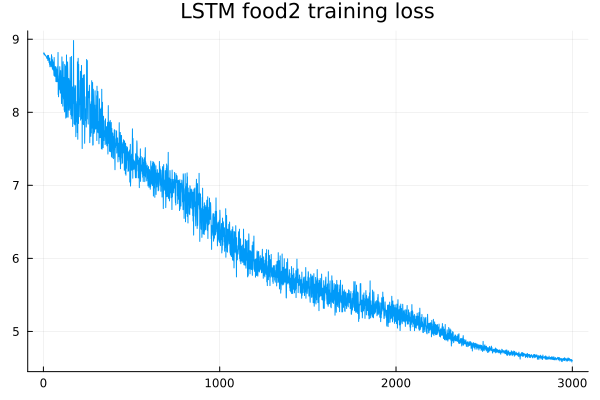

In [29]:
rnn_model5 =  Chain( LSTM(2=>6) , LSTM(6=>4) , Dense(4=>3,sigmoid) , softmax ) #same model
opt = Flux.setup( Flux.Adam(0.001) , rnn_model5 ) #same optimizer
#change the batch size so that multiple sequence samples are passed at the same time
data = Flux.DataLoader( ( x_train_new , y_train_new ) , batchsize = 10 , shuffle = true )

losses = []
for epoch in 1:100
    
    for ( x , y ) in data 
        #x is a 10 element vector, x[1] is a (8,2) matrix, and Flux.unstack(x[1],dims=1) makes vector of 8 holding (2,)
 
        x_batch_tt = reduce( hcat , map( dat -> Flux.unstack(dat,dims=1) , x ) )
        y_batch_tt = reduce( hcat , map( dat -> Flux.unstack(dat,dims=1) , y ) )#hcat(Flux.unstack(y[1],dims=1),Flux.unstack(y[1],dims=1))
        
        Flux.reset!(rnn_model5) #important or else the model takes the 'hidden' values from previous usage 
        
        loss_tmp, grads = Flux.withgradient( rnn_model5 ) do model
            loss = 0
            for ii in 1:size( x_batch_tt )[1]
                y_hat = model( Float32.(Flux.stack( x_batch_tt[ii,:], dims=2)) )
                loss += Flux.crossentropy( y_hat , Float32.(Flux.stack( y_batch_tt[ii,:], dims=2)) )
            end
            
            return loss
        end
        
        Flux.update!( opt , rnn_model5 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
        #break
    end
    
end
p1 = plot( losses , title="LSTM food2 training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)


In [30]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model5 )
    y_hat = []
    for ii in 1:length(x_us)    
        
        meal = Flux.onecold( rnn_model5(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "soup", "steak", "steak", "steak", "steak", "soup", "steak"]
y_hat: Any["steak", "soup", "steak", "steak", "steak", "steak", "soup", "steak"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken"

# <span style="color:orange"> We can try another approach which avoids the DataLoader and make a custom form of batching and shuffling all while using a single data structure (tensor, 3D array)</span>

- Let us make a 3D matrix (tensor in ML parlance) to hold the different feature sequences
- The function 'batch' makes adds an extra dimension for the index of the member element so that we can have a set of matrices of number N and each matrix is 10x20 and then we get 10x20xN

In [31]:
#put the label data into one-hot-batch
x_train = [ Flux.onehotbatch( x_train_cold[ii] , x_categories ) for ii in 1:length(x_train_cold) ]
x_test = [ Flux.onehotbatch( x_test_cold[ii] , x_categories ) for ii in 1:length(x_test_cold) ];
y_train = [ Flux.onehotbatch( y_train_cold[ii] , y_categories ) for ii in 1:length(y_train_cold) ];
y_test = [ Flux.onehotbatch( y_test_cold[ii] , y_categories ) for ii in 1:length(y_test_cold) ];
x_train[1]

2×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  1  1  1  ⋅  ⋅
 1  ⋅  1  ⋅  ⋅  ⋅  1  1

In [32]:
x_train_batch = Float32.(Flux.batch( x_train )) #make a batch
y_train_batch = Float32.(Flux.batch( y_train )) #make a batch
display( size(x_train_batch) )
display( x_train_batch[:,:,1] )
println("----------------------------------------------")
display( size(y_train_batch) )
display( y_train_batch[:,:,1] )

(2, 8, 300)

2×8 Matrix{Float32}:
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0

----------------------------------------------


(3, 8, 300)

3×8 Matrix{Float32}:
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0

In [33]:
display( x_train_batch[:,:,[1,4]] ) #2 sequences

2×8×2 Array{Float32, 3}:
[:, :, 1] =
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0

[:, :, 2] =
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [34]:
rnn_model6 = Chain( LSTM(2=>6) , LSTM(6=>4) , Dense(4=>3,sigmoid) , softmax ) #same model
display( rnn_model6( x_train_batch[:,1,[1]] ) )
display( rnn_model6( x_train_batch[:,1,[1,4]] ) )

3×1 Matrix{Float32}:
 0.33375663
 0.33285454
 0.3333889

3×2 Matrix{Float32}:
 0.33431   0.33184
 0.332271  0.33491
 0.333419  0.33325

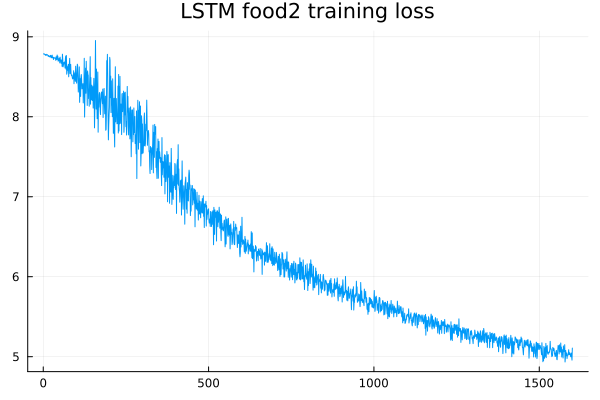

In [35]:
rnn_model6 =  Chain( LSTM(2=>6) , LSTM(6=>4) , Dense(4=>3,sigmoid) , softmax ) #same model
opt = Flux.setup( Flux.Adam(0.001) , rnn_model6 ) #same optimizer
#not using the DataLoader and doing the batching manually
#data=Flux.DataLoader((x_train_new,y_train_new),batchsize=10,shuffle=true)
batch_size = 10
sample_size = size(x_train_batch)[3]
losses = []
for epoch in 1:1600
    
    sample_num = rand( 1:sample_size , batch_size )
    x_batch_tmp = x_train_batch[:,:,sample_num]
    y_batch_tmp = y_train_batch[:,:,sample_num]
       
    Flux.reset!(rnn_model6) #important or else the model takes the 'hidden' values from previous usage        
    loss_tmp, grads = Flux.withgradient( rnn_model6 ) do model
        loss = 0
        for jj in 1:size( x_batch_tmp )[2]
            
            y_hat = model( Float32.( x_batch_tmp[:,jj,:] ) )
            loss += Flux.crossentropy( y_hat , y_batch_tmp[:,jj,:] )
        end
        return loss
    end

    Flux.update!( opt , rnn_model6 , grads[1] )
    push!( losses , loss_tmp ) #don't put this in the above block where the gradient is computed
    
end
p1 = plot( losses , title="LSTM food2 training loss" , legend=false )
savefig( p1 , "p1.png" )
display( p1 )


In [36]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model6 )
    y_hat = []
    for ii in 1:length(x_us)    
        
        meal = Flux.onecold( rnn_model6(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["steak", "soup", "soup", "steak", "soup", "steak", "steak", "steak"]
y_hat: Any["steak", "soup", "soup", "steak", "soup", "steak", "steak", "steak"]
       y: ["steak", "chicken", "soup", "soup", "steak", "soup", "steak", "steak"]
y_hat: Any["steak", "chicken", "soup", "soup", "steak", "soup", "steak", "steak"]
       y: ["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["steak", "chicken", "chicken", "soup", "steak", "steak", "steak", "steak"]
y_hat: Any["steak", "chicken", "chicken", "soup", "steak", "steak", "steak", "steak"]
       y: ["soup", "steak", "soup", "steak", "steak", "steak", "steak", "soup"]
y_hat: Any["soup", "steak", "soup", "steak", "steak", "steak", "steak", "soup"]
       y: ["soup", "steak", "soup", "steak", "steak", "steak", "steak", "steak"]
y_hat: Any["soup", "steak", "soup", "steak", "steak", "steak", "steak

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.codeproject.com%2FArticles%2F3993967%2FApplying-Long-Short-Term-Memory-for-Video-Classifi&psig=AOvVaw3aJjMa8pFFZ1i53Lk2C-gE&ust=1673466988547000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCNjijr7kvfwCFQAAAAAdAAAAABA4)

![rnn](./rnnTypes.jpg)

### <span style="color:orange">Let's consider the <u>**sequence to one**</u> (seq-to-one) now</span>

#### <span style="color:orange"> <u>Many-to-One Sequence Problems</u>. In many-to-one sequence problems, we have a sequence of data as input, and we have to predict a single output. Sentiment analysis or text classification is one such use case. Eg, after seeing a sequence of words try to predict the 'sentiment'. It is necessary to step through the sequence, passing in the X vectors of features to allow the hidden vector to propagate and ignore the Y vector outputs untill the final step </span>



In [37]:
x_dim = 2
h_dim = 4
y_dim = 3
rnn_model7 = Chain( RNN( x_dim => h_dim ) , Dense( h_dim => y_dim , relu ), softmax )
#loss function for 3-to-1, a sequence of 3 inputs for a single output
#this can be used in the training scheme as before
function loss_3_to_1( x , y ) #assume feature data has 3 samples
    Flux.reset!(rnn_model7)
    rnn_model7( x[1] ) # ignores the output but updates the hidden states
    rnn_model7( x[2] ) # ignores the output but updates the hidden states again
    y_hat = rnn_model7( x[3] )
    println( y_hat )
    println( size(y) )
    Flux.crossentropy( y_hat , y )
end

y = rand( Float32 , y_dim ) #target data
x = [ rand(Float32, x_dim ) for i=1:3 ] #sequence of 3 x values

loss_3_to_1( x , y )

Float32[0.33333334, 0.33333334, 0.33333334]
(3,)


1.2717011f0

### <span style="color:orange">Produce some data relevant to sentiment (synthetic)</span>


In [90]:
happy_sentences = []
push!( happy_sentences , "Good morning Alex" )
push!( happy_sentences , "Good morning Bob" )
push!( happy_sentences , "Good morning Craig" )
push!( happy_sentences , "Great day Derek" )
push!( happy_sentences , "Great day Elyse" )
push!( happy_sentences , "Good night Frank" )
push!( happy_sentences , "Good night Greg" )
push!( happy_sentences , "Nice work Hamish" )
push!( happy_sentences , "Nice paper Irene" )
push!( happy_sentences , "Super success Jack" )
neutral_sentences = []
push!( neutral_sentences , "Ok bye Alex" )
push!( neutral_sentences , "Fine ok Bob" )
push!( neutral_sentences , "Pay now Craig" )
push!( neutral_sentences , "See you Derek" )
push!( neutral_sentences , "Ok go Elyse" )
push!( neutral_sentences , "See you Frank" )
push!( neutral_sentences , "Just now Greg" )
push!( neutral_sentences , "Well ok Hamish" )
push!( neutral_sentences , "It is Irene" )
sad_sentences = []
push!( sad_sentences , "Raining day Alex" )
push!( sad_sentences , "Hurricane coming Bob" )
push!( sad_sentences , "Storm coming Craig" )
push!( sad_sentences , "Storm approaching Derek" )
push!( sad_sentences , "Danger coming Elyse" )
push!( sad_sentences , "Watch out Frank" )
push!( sad_sentences , "Watch out Greg" )
push!( sad_sentences , "Bad luck Hamish" )
push!( sad_sentences , "Bad weather Irene" );


In [91]:
vocabulary = []
for sentence_array in [happy_sentences,neutral_sentences,sad_sentences]
    for sentence in sentence_array
        push!(vocabulary,split(sentence," ")...)
    end    
end
vocabulary = sort(unique(vocabulary));
println( vocabulary[1:7] )
println( vocabulary[end-7:end] )
display( Flux.onehotbatch(["Alex","Elyse","now","you"], vocabulary) )

Any["Alex", "Bad", "Bob", "Craig", "Danger", "Derek", "Elyse"]
Any["now", "ok", "out", "paper", "success", "weather", "work", "you"]


44×4 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋮        
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1

In [92]:
Flux.onehotbatch(split(happy_sentences[1]," "),vocabulary)

44×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 1  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋮     
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  1  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

In [93]:
x_train = []
y_categories = ["happy","neutral","sad"]
y_train = []
for (type_ind,sentence_array) in enumerate( [happy_sentences,neutral_sentences,sad_sentences] )
    [ push!( x_train , Flux.onehotbatch(split(sentence_array[ii]," "),vocabulary) ) for ii in 1:length(sentence_array) ]
    [ push!( y_train , Float32.(Flux.onehot(y_categories[type_ind],y_categories)) ) for ii in 1:length(sentence_array) ]
end
println( length(x_train) )
println( size(x_train) )
display(x_train[3])
display( y_train[1:4] ); display( y_train[end-4:end] )

28
(28,)


44×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  1
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 1  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋮     
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  1  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

4-element Vector{Any}:
 Float32[1.0, 0.0, 0.0]
 Float32[1.0, 0.0, 0.0]
 Float32[1.0, 0.0, 0.0]
 Float32[1.0, 0.0, 0.0]

5-element Vector{Any}:
 Float32[0.0, 0.0, 1.0]
 Float32[0.0, 0.0, 1.0]
 Float32[0.0, 0.0, 1.0]
 Float32[0.0, 0.0, 1.0]
 Float32[0.0, 0.0, 1.0]

In [94]:
x_train_batch = Float32.(Flux.batch( x_train )) #make a batch
display( size(x_train_batch) )
display( x_train_batch[:,:,1] )

(44, 3, 28)

44×3 Matrix{Float32}:
 0.0  0.0  1.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [95]:
rnn_model7 =  Chain( LSTM(size(x_train_batch)[1]=>12) , LSTM(12=>6) , Dense(6=>length(y_train[1]),sigmoid) , softmax )
rnn_model7( x_train_batch[:,1,1] )

3-element Vector{Float32}:
 0.33310467
 0.33427247
 0.33262286

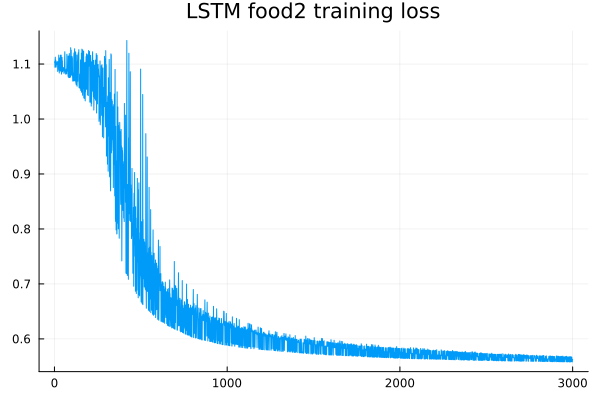

In [96]:
feature_length = size(x_train_batch)[1]
target_length = length(y_train[1])
rnn_model7 =  Chain( LSTM(feature_length=>12) , LSTM(12=>6) , Dense(6=>target_length,sigmoid) , softmax )

opt = Flux.setup( Flux.Adam(0.001) , rnn_model7 ) #same optimizer
#not using the DataLoader and doing the batching manually
batch_size = 1
sample_size = size(x_train_batch)[3]
losses = []
for epoch in 1:3000
    
    sample_num = rand( 1:sample_size , batch_size )
    x_batch_tmp = x_train_batch[:,:,sample_num]
    #display(x_batch_tmp)
    y_batch_tmp = y_train[sample_num]
#     display(y_batch_tmp)
#     display("-----------")
#     break
       
    Flux.reset!(rnn_model7) #important or else the model takes the 'hidden' values from previous usage        
    loss_tmp, grads = Flux.withgradient( rnn_model7 ) do model
        loss = 0
        for jj in 1:size( x_batch_tmp )[2]
#             println("jj=$(jj)")
#             println(size(x_batch_tmp))
            y_hat = model( Float32.( x_batch_tmp[:,jj,:] ) )
#             println(y_hat)
            if( jj == size( x_batch_tmp )[2] ) #only find the loss at the end
#                 println("->", y_train[sample_num][:] )
#                 println("->", y_batch_tmp[1]  )
#                 println("->", y_hat  )
                loss += Flux.crossentropy( y_hat ,  y_batch_tmp[1] )
            end
        end
        return loss
    end

    Flux.update!( opt , rnn_model7 , grads[1] )
    push!( losses , loss_tmp ) #don't put this in the above block where the gradient is computed
    
end
p1 = plot( losses , title="LSTM food2 training loss" , legend=false )
savefig( p1 , "p1.png" )
display( p1 )


In [111]:
Flux.reset!(rnn_model7)
s1 =  "Super success Jack" 
w1 = split( s1 , " " ) 
rnn_model7( Flux.onehot( w1[1] , vocabulary ) );
rnn_model7( Flux.onehot( w1[2] , vocabulary ) );
y_final = rnn_model7( Flux.onehot( w1[3] , vocabulary ) )
println( "Super success Jack -> " , Flux.onecold( y_final , y_categories ) )

Flux.reset!(rnn_model7)
s2 =  "Ok bye Alex"
w2 = split( s2 , " " ) 
map( ss -> rnn_model7(Flux.onehot(w2[ss],vocabulary)) , 1:length(w2)-1 )
y_final = rnn_model7( Flux.onehot( w2[end] , vocabulary ) )
println( "Ok bye Alex -> " , Flux.onecold( y_final , y_categories ) )

Flux.reset!(rnn_model7)
s3 = "Storm coming Craig"
w3 = split( s3 , " " ) 
map( ss -> rnn_model7(Flux.onehot(w3[ss],vocabulary)) , 1:length(w3)-1 )
y_final = rnn_model7( Flux.onehot( w3[end] , vocabulary ) )
println( "Storm coming Craig -> " , Flux.onecold( y_final , y_categories ) )

#new sentence not in training
Flux.reset!(rnn_model7)
s_new =  "Super success Irene" 
w_new = split( s_new , " " ) 
map( ss -> rnn_model7(Flux.onehot( w_new[ss],vocabulary)) , 1:length(w_new)-1 )
y_final = rnn_model7( Flux.onehot( w_new[end] , vocabulary ) )
println( "(new) Super success Irene -> " , Flux.onecold( y_final , y_categories ) )

#new sentence not in training
Flux.reset!(rnn_model7)
s_new =  "Hurricane success Irene" 
w_new = split( s_new , " " ) 
map( ss -> rnn_model7(Flux.onehot( w_new[ss],vocabulary)) , 1:length(w_new)-1 )
y_final = rnn_model7( Flux.onehot( w_new[end] , vocabulary ) )
println( "(new) Hurricane success Irene -> " , Flux.onecold( y_final , y_categories ) )

Super success Jack -> happy
Ok bye Alex -> neutral
Storm coming Craig -> sad
(new) Super success Irene -> happy
(new) Hurricane success Irene -> sad


In [98]:
print(vocabulary)

Any["Alex", "Bad", "Bob", "Craig", "Danger", "Derek", "Elyse", "Fine", "Frank", "Good", "Great", "Greg", "Hamish", "Hurricane", "Irene", "It", "Jack", "Just", "Nice", "Ok", "Pay", "Raining", "See", "Storm", "Super", "Watch", "Well", "approaching", "bye", "coming", "day", "go", "is", "luck", "morning", "night", "now", "ok", "out", "paper", "success", "weather", "work", "you"]

### <span style="color:orange">One to many RNN</span>

- Take a single X input and then output a series of Y outputs
- Some architectures will require a bit of manual construction
- One-to-many sequence problems are sequence problems where the input data has one time-step, and the output contains a vector of multiple values or multiple time-steps. Thus, we have a single input and a sequence of outputs.
A typical example is image captioning, where the description of an image is generated. Or music generation from a description.

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fdiscuss.pytorch.org%2Ft%2Fone-to-many-lstm%2F96932&psig=AOvVaw0Ha6GO6T8UyXiD-It1widc&ust=1673625753189000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCMie7vWzwvwCFQAAAAAdAAAAABBa)

![rnn](./rnn1toMany.jpeg)

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fdiscuss.pytorch.org%2Ft%2Fone-to-many-lstm%2F96932&psig=AOvVaw0Ha6GO6T8UyXiD-It1widc&ust=1673625753189000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCMie7vWzwvwCFQAAAAAdAAAAABBa)

![rnn](./one-to-many.png)

### In this case we must make sure the 'hidden' state values are cycled as inputs and the previous unit definitions abstract away that hidden unit productions. The units must return the states (hidden) so be passed as subsequent inputs.

#### instead of having Flux handle the internal state (h) we can maintain it explicitly

In [12]:
#create a RNN cell which does not handle internal state automatically
#which means that we have to retrieve the 'h' state value and pass it back in to the next step
x_dim = 2
h_dim = 2
h_init = rand( Float32 , h_dim )
x_init = rand( Float32 , x_dim )

rnn1 = Flux.RNNCell( x_dim, h_dim, sigmoid ) #define x_dim and then h_dim

h , y = rnn1( h_init , x_init ) #pass h and then x to get the h and y outputs

(Float32[0.23961921, 0.5914116], Float32[0.23961921, 0.5914116])

In [18]:
#Now we pass the outputs 'y' from the rnn units as 'x' data in subsequent steps
x_dim = 2
h_dim = 2
h_init = rand( Float32 , h_dim )
x_init = rand( Float32 , x_dim )

rnn1 = Flux.RNNCell( x_dim, h_dim, sigmoid ) #define x_dim and then h_dim
m1 = Flux.Dense( 2 => 1 , sigmoid )

h , y = rnn1( h_init , x_init ) #pass h and then x to get the h and y outputs

h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
y_hat = m1( y )

1-element Vector{Float32}:
 0.6980755

In [17]:
nsteps = 4
xs = [rand(Float32, 3, 2) for i in 1:nsteps]
display( xs )
m = Chain(RNN(3, 5))
[ display(m(x)) for x = xs] 

4-element Vector{Matrix{Float32}}:
 [0.7193387 0.33868003; 0.016090214 0.256925; 0.2488938 0.47927523]
 [0.56273735 0.5567441; 0.20874453 0.45442927; 0.6528861 0.7265376]
 [0.5801285 0.41532242; 0.91156983 0.92337066; 0.66897005 0.5273158]
 [0.73792315 0.7799565; 0.5407746 0.5092; 0.6379438 0.23041004]

5×2 Matrix{Float32}:
 -0.344579  -0.125573
 -0.119549  -0.341085
  0.22776    0.012745
 -0.451451  -0.568937
  0.337278  -0.00986344

5×2 Matrix{Float32}:
  0.138712    0.112828
 -0.326718   -0.57339
 -0.0753149  -0.490038
 -0.862643   -0.845221
  0.167302    0.156598

5×2 Matrix{Float32}:
  0.477808   0.602143
 -0.618007  -0.544691
 -0.528367  -0.617153
 -0.925458  -0.913587
  0.371714   0.403402

5×2 Matrix{Float32}:
  0.738152   0.738869
 -0.659737  -0.444979
 -0.471581  -0.31129
 -0.907443  -0.83823
  0.788016   0.860447

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [14]:
### <span style="color:orange">write a function and make a function for the gradient of the function</span>